In [12]:
# import required packages (general)

import pandas as pd
import numpy as np
from numpy import array
from sklearn import preprocessing
from sklearn import tree
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns; sns.set()


# import library class for feature selection via tree based classifier

from sklearn.ensemble import ExtraTreesClassifier


# import library classes for classification evaluation

from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score


# import library classes for ANN

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedShuffleSplit


# import class for categorical missing value imputation

from sklearn.impute import SimpleImputer


# import classes for MICE missing value imputation

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# SimpleImputer code inspiration from https://machinelearningknowledge.ai/how-to-use-sklearn-simple-imputer-simpleimputer-for-filling-missing-values-in-dataset/ and https://dzone.com/articles/imputing-missing-data-using-sklearn-simpleimputer
# MICE code inspiration from https://towardsdatascience.com/3-underrated-strategies-to-deal-with-missing-values-a539fb6c0690
# Grid search code inspiration from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 
# ANN code inspiration from https://medium.datadriveninvestor.com/hyperparameter-tuning-with-deep-learning-grid-search-8630aa45b2da and https://medium.datadriveninvestor.com/hyperparameter-tuning-with-deep-learning-grid-search-8630aa45b2da and https://medium.com/@am.benatmane/keras-hyperparameter-tuning-using-sklearn-pipelines-grid-search-with-cross-validation-ccfc74b0ce9f

# DATA IMPORT

In [13]:
# importing data from Excel into a pandas dataframe and display dataframe

dataFrame = pd.read_excel('DatasetAdherence_fromIntroAndBaseline.xlsx')
dataFrame

,gender,age,occupation,manager,work,tenure,current,frontline,change,change_other,...,olbi,phq,ptsd,req,pssRecoded,recovery,SocialSupport,Control,smbq,Adhered
0,1.0,54.0,6.0,1.0,1.0,NaN,4.0,3.0,1.0,1.0,...,2.285714,1.0,1.000000,4.9,2.7,4.666667,4.2,4.428571,2.833333,0
1,1.0,35.0,5.0,2.0,1.0,3.0,2.0,1.0,1.0,2.0,...,1.857143,1.0,1.000000,7.0,1.5,7.000000,4.8,6.142857,2.833333,0
2,1.0,29.0,2.0,2.0,7.0,2.0,1.0,4.0,1.0,2.0,...,2.000000,1.5,2.666667,6.4,1.5,6.000000,5.6,6.571429,2.000000,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,...,1.857143,1.5,1.000000,5.8,1.6,5.500000,4.2,5.285714,2.666667,0
4,1.0,45.0,6.0,1.0,1.0,2.0,3.0,2.0,1.0,2.0,...,2.428571,2.5,2.000000,2.9,2.4,2.500000,3.6,4.285714,4.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,1.0,57.0,1.0,2.0,1.0,4.0,4.0,3.0,2.0,2.0,...,1.285714,2.5,1.333333,5.8,1.4,5.333333,4.4,5.142857,1.333333,0
279,1.0,41.0,5.0,2.0,1.0,4.0,5.0,1.0,2.0,1.0,...,1.571429,1.0,1.000000,5.2,1.5,5.000000,4.0,5.285714,1.833333,0
280,1.0,34.0,3.0,2.0,1.0,2.0,4.0,2.0,1.0,1.0,...,2.285714,1.0,1.666667,5.1,2.3,4.833333,5.2,5.285714,3.500000,0
281,1.0,28.0,3.0,2.0,7.0,2.0,1.0,2.0,2.0,1.0,...,3.285714,3.0,2.666667,5.0,3.5,4.333333,3.2,4.714286,5.166667,0


In [14]:
# only take psychometric inventories columns as features

dataFrame = dataFrame[['age', 'current', 'gad', 'jcq', 'smbq', 'req', 'maas', 'pssRecoded', 'phq', 'olbi', 'ptsd', 'Adhered']]

# DATA IMPUTATION

In [15]:
# compute sum of missing values per column

dataFrame.isnull().sum() 

age            4
current        7
gad           14
jcq            9
smbq          13
req           13
maas          15
pssRecoded    16
phq           14
olbi          11
ptsd          15
Adhered        0
dtype: int64

In [16]:
# impute missing categorical values with the most frequent value

simpleImputer = SimpleImputer (strategy='most_frequent')
dataFrame.current = simpleImputer.fit_transform(dataFrame['current'].values.reshape(-1,1))[:,0]

/Users/janlorenz/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [17]:
# impute missing continual values with MICE, take the values in a dataframe, redefine the columns and display imputed data frame

imputerMICE = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataFrame = imputerMICE.fit_transform(dataFrame)
imputed_dataFrame = pd.DataFrame(imputed_dataFrame)
imputed_dataFrame.columns = ['age', 'current', 'gad', 'jcq', 'smbq', 'req', 'maas', 'pssRecoded', 'phq', 'olbi', 'ptsd', 'Adhered']
imputed_dataFrame

/Users/janlorenz/opt/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


,age,current,gad,jcq,smbq,req,maas,pssRecoded,phq,olbi,ptsd,Adhered
0,54.000000,4.0,1.142857,4.111111,2.833333,4.900000,3.0,2.700000,1.000000,2.285714,1.000000,0.0
1,35.000000,2.0,1.000000,5.111111,2.833333,7.000000,2.0,1.500000,1.000000,1.857143,1.000000,0.0
2,29.000000,1.0,2.285714,5.888889,2.000000,6.400000,2.4,1.500000,1.500000,2.000000,2.666667,0.0
3,52.814126,5.0,1.142857,4.111111,2.666667,5.800000,3.0,1.600000,1.500000,1.857143,1.000000,0.0
4,45.000000,3.0,1.857143,4.222222,4.000000,2.900000,3.2,2.400000,2.500000,2.428571,2.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
278,57.000000,4.0,1.142857,4.333333,1.333333,5.800000,1.4,1.400000,2.500000,1.285714,1.333333,0.0
279,41.000000,5.0,1.142857,4.444444,1.833333,5.200000,1.4,1.500000,1.000000,1.571429,1.000000,0.0
280,34.000000,4.0,1.571429,5.000000,3.500000,5.100000,4.0,2.300000,1.000000,2.285714,1.666667,0.0
281,28.000000,1.0,2.142857,3.333333,5.166667,5.000000,5.2,3.500000,3.000000,3.285714,2.666667,0.0


In [18]:
# compute sum of missing values per column to check if there are no more missing values

imputed_dataFrame.isnull().sum()

age           0
current       0
gad           0
jcq           0
smbq          0
req           0
maas          0
pssRecoded    0
phq           0
olbi          0
ptsd          0
Adhered       0
dtype: int64

# FEATURE SELECTION

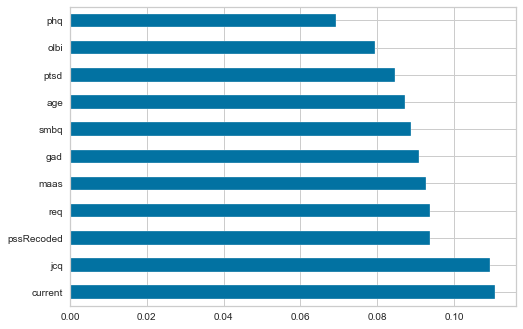

In [8]:
# feature selection via tree based classifiers

X = imputed_dataFrame.iloc[:,0:11]  # feature columns
y = imputed_dataFrame.iloc[:,-1]    # classifier column
featureModel = ExtraTreesClassifier()
featureModel.fit(X,y)

# plotting of feature importances for visualization

feat_importances = pd.Series(featureModel.feature_importances_, index=X.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

# DATA PREPROCESSING

In [19]:
# normalise the data and display the imputed normalised data frame

x = imputed_dataFrame.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
imputed_dataFrame_norm = pd.DataFrame(x_scaled, columns=imputed_dataFrame.columns)
imputed_dataFrame_norm

,age,current,gad,jcq,smbq,req,maas,pssRecoded,phq,olbi,ptsd,Adhered
0,0.491803,0.75,0.047619,0.431818,0.305556,0.603774,0.357143,0.472222,0.000000,0.428571,0.000000,0.0
1,0.180328,0.25,0.000000,0.636364,0.305556,1.000000,0.178571,0.138889,0.000000,0.285714,0.000000,0.0
2,0.081967,0.00,0.428571,0.795455,0.166667,0.886792,0.250000,0.138889,0.166667,0.333333,0.454545,0.0
3,0.472363,1.00,0.047619,0.431818,0.277778,0.773585,0.357143,0.166667,0.166667,0.285714,0.000000,0.0
4,0.344262,0.50,0.285714,0.454545,0.500000,0.226415,0.392857,0.388889,0.500000,0.476190,0.272727,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
278,0.540984,0.75,0.047619,0.477273,0.055556,0.773585,0.071429,0.111111,0.500000,0.095238,0.090909,0.0
279,0.278689,1.00,0.047619,0.500000,0.138889,0.660377,0.071429,0.138889,0.000000,0.190476,0.000000,0.0
280,0.163934,0.75,0.190476,0.613636,0.416667,0.641509,0.535714,0.361111,0.000000,0.428571,0.181818,0.0
281,0.065574,0.00,0.380952,0.272727,0.694444,0.622642,0.750000,0.694444,0.666667,0.761905,0.454545,0.0


# DATA DIVISION IN TEST AND TRAIN

In [20]:
# put features in X and classifiers in y, split in test and train sets

X = imputed_dataFrame_norm.drop('Adhered', axis=1)
y = imputed_dataFrame_norm['Adhered']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42, stratify = y)

# ML MODELS

## DECISION TREE

Fitting 5 folds for each of 40000 candidates, totalling 200000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 1680 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 5680 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 11280 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 18480 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 27280 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 37680 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 49680 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 63280 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 78480 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 95280 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 113680 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 133680 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 155280 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1

Best parameters: DecisionTreeClassifier(class_weight='balanced', max_depth=5, max_features=1,
                       min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=42, splitter='random')
Balanced Accuracy Score : 0.448626045400239
Accuracy Score : 0.5176470588235295
Precision Score : 0.6031746031746031
Recall Score : 0.7037037037037037
F1 Score : 0.6495726495726495


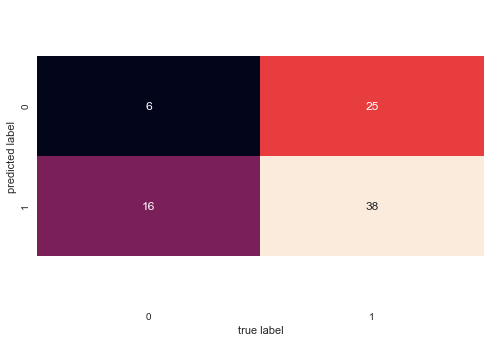

In [12]:
# define parameters for grid search

criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, len(X.columns), num = 20)]
parameters      = {'criterion': criterion_values,
                   'splitter': splitter_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'max_features': max_features_values,
                   'class_weight': ['balanced']
                  }

dt = tree.DecisionTreeClassifier(random_state = 42)

clf = GridSearchCV(      estimator           = dt, 
                         param_grid          = parameters,
                         scoring             = 'balanced_accuracy',
                         verbose             = 1,
                         n_jobs              = -1
                         )
clf_result = clf.fit(X_train, y_train)

y_pred_acc = clf_result.predict(X_test)

# print the parameters that led to the best results

print('Best parameters: ' + str(clf_result.best_estimator_))

# pint model evaluation metrics 

print('Balanced Accuracy Score : ' + str(balanced_accuracy_score(y_test,y_pred_acc)))
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))

# set up and display confusion matrix

mat = confusion_matrix(y_pred_acc, y_test)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # add 0.5 to the bottom
t -= 0.5 # subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

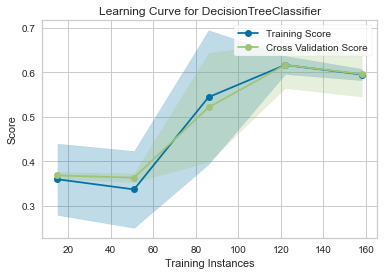

<AxesSubplot:title={'center':'Learning Curve for DecisionTreeClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [13]:
# set up and display the learning curve

fig, ax = plt.subplots(figsize=(6, 4))
lc3_viz = LearningCurve(tree.DecisionTreeClassifier(class_weight='balanced', max_depth=5, max_features=1,
                       min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=42, splitter='random'), cv = 5)
lc3_viz.fit(X_train, y_train)
lc3_viz.poof()

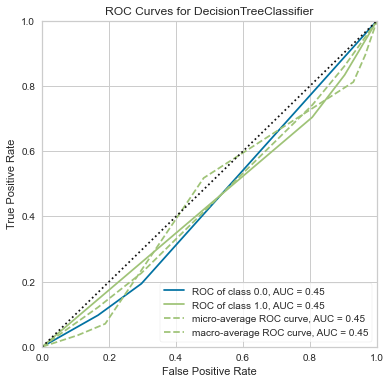

<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [14]:
# set up and display the ROC curves

fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(tree.DecisionTreeClassifier(class_weight='balanced', max_depth=5, max_features=1,
                       min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=42, splitter='random'), cv = 5)
roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test) 
roc_viz.poof()

0.6102472309742433


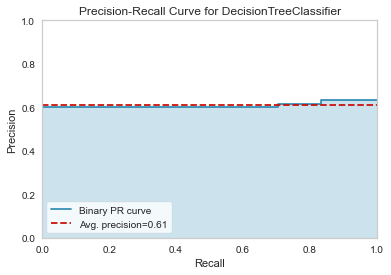

<AxesSubplot:title={'center':'Precision-Recall Curve for DecisionTreeClassifier'}, xlabel='Recall', ylabel='Precision'>

In [15]:
# set up and display the Precision Recall curve

fig, ax = plt.subplots(figsize=(6, 4)) 
viz = PrecisionRecallCurve(tree.DecisionTreeClassifier(class_weight='balanced', max_depth=5, max_features=1,
                       min_samples_leaf=0.1, min_samples_split=0.1,
                       random_state=42, splitter='random'), cv = 5)
viz.fit(X_train, y_train)
print(viz.score(X_test, y_test))
viz.poof()

## RANDOM FOREST

Fitting 5 folds for each of 21600 candidates, totalling 108000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

Best parameters: RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=30, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=10, random_state=42)
Balanced Accuracy Score : 0.5361409796893668
Accuracy Score : 0.5764705882352941
Precision Score : 0.6607142857142857
Recall Score : 0.6851851851851852
F1 Score : 0.6727272727272727


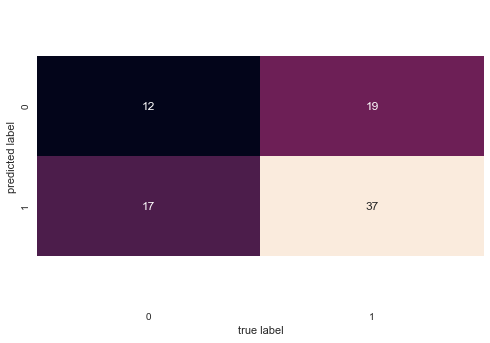

In [11]:
# define parameters for grid search

n_estimators_values      = [int(x) for x in np.linspace(10, 1000, num = 25)]
criterion_values         = ['gini', 'entropy']
class_weight_values      = ['balanced']
max_features_values      = ['auto', 'sqrt']
max_depth_values         = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters      = {'n_estimators': n_estimators_values,
                   'criterion': criterion_values,
                   'max_features': max_features_values,
                   'max_depth': max_depth_values,
                   'min_samples_split': min_samples_split_values,
                   'min_samples_leaf': min_samples_leaf_values,
                   'bootstrap': bootstrap_values,
                   'class_weight': class_weight_values
                  }

rf = RandomForestClassifier(random_state = 42)

clf = GridSearchCV(      estimator           = rf, 
                         param_grid          = parameters,
                         scoring             = 'balanced_accuracy',
                         verbose             = 1,
                         n_jobs              = -1
                         )
clf_result = clf.fit(X_train, y_train)

y_pred_acc = clf_result.predict(X_test)

# print the parameters that led to the best results

print('Best parameters: ' + str(clf_result.best_estimator_))

# pint model evaluation metrics 

print('Balanced Accuracy Score : ' + str(balanced_accuracy_score(y_test,y_pred_acc)))
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))

# set up and display confusion matrix

mat = confusion_matrix(y_pred_acc, y_test)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # add 0.5 to the bottom
t -= 0.5 # subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

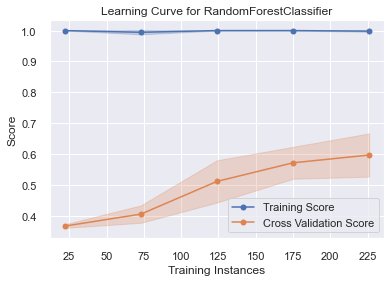

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [23]:
# set up and display the learning curve

fig, ax = plt.subplots(figsize=(6, 4))
lc3_viz = LearningCurve(RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=30, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=10, random_state=42), cv = 5)
lc3_viz.fit(X, y)
lc3_viz.poof()

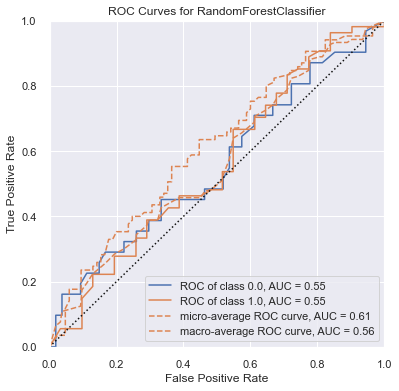

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [25]:
# set up and display the ROC curves

fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=30, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=10, random_state=42))
roc_viz.fit(X_train, y_train)
roc_viz.score(X_test, y_test) 
roc_viz.poof()

0.6759923645246703


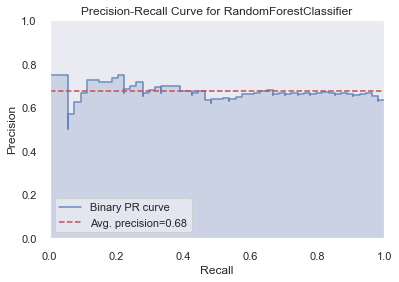

<AxesSubplot:title={'center':'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [26]:
# set up and display the Precision Recall curve

fig, ax = plt.subplots(figsize=(6, 4)) 
viz = PrecisionRecallCurve(RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       criterion='entropy', max_depth=30, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=10, random_state=42), cv = 5)
viz.fit(X_train, y_train)
print(viz.score(X_test, y_test))
viz.poof()

## SUPPORT VECTOR MACHINE

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:    1.7s finished


Best parameters: SVC(C=10, class_weight='balanced', gamma=1, kernel='sigmoid', random_state=42)
Balanced Accuracy Score : 0.6445639187574671
Accuracy Score : 0.6705882352941176
Precision Score : 0.7407407407407407
Recall Score : 0.7407407407407407
F1 Score : 0.7407407407407407


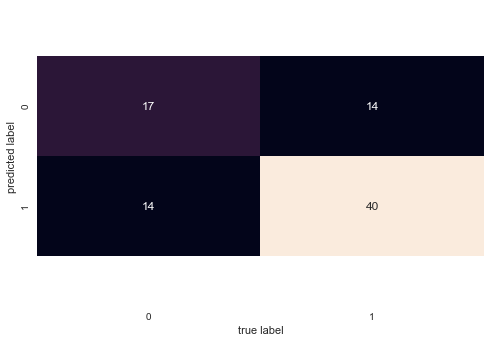

In [16]:
# define parameters for grid search

c_values                 = [0.1, 1, 10, 100]
gamma_values             = [1, 0.1, 0.01, 0.001]
kernel_values            = ['linear', 'rbf', 'poly', 'sigmoid']
class_weight_values      = ['balanced']
max_depth_values.append(None)
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values  = [1, 2, 4]
bootstrap_values         = [True, False]
parameters      = {'C': c_values,
                   'gamma': gamma_values,
                   'kernel': kernel_values,
                   'class_weight': class_weight_values
                  }

svm = SVC(random_state = 42)

clf = GridSearchCV(      estimator           = svm, 
                         param_grid          = parameters,
                         scoring             = 'balanced_accuracy',
                         verbose             = 1,
                         n_jobs              = -1
                         )
clf_result = clf.fit(X_train, y_train)

y_pred_acc = clf_result.predict(X_test)

# print the parameters that led to the best results

print('Best parameters: ' + str(clf_result.best_estimator_))

# pint model evaluation metrics 

print('Balanced Accuracy Score : ' + str(balanced_accuracy_score(y_test,y_pred_acc)))
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))

# set up and display confusion matrix

mat = confusion_matrix(y_pred_acc, y_test)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # add 0.5 to the bottom
t -= 0.5 # subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

0.782832552398206


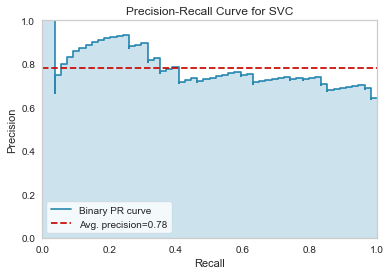

<AxesSubplot:title={'center':'Precision-Recall Curve for SVC'}, xlabel='Recall', ylabel='Precision'>

In [17]:
# set up and display the Precision Recall curve

fig, ax = plt.subplots(figsize=(6, 4)) 
viz = PrecisionRecallCurve(SVC(C=10, class_weight='balanced', gamma=1, kernel='sigmoid', random_state=42), cv = 5)
viz.fit(X_train, y_train)
print(viz.score(X_test, y_test))
viz.poof()

## ARTIFICIAL NEURAL NETWORK

In [18]:
# define model function for grid search

def create_model(learning_rate, dropout_rate, activation_function, init, neuron1, neuron2):
    model = Sequential()
    model.add(Dense(neuron1,input_dim = 11, input_shape=(X.shape[1],), kernel_initializer = init, activation = activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neuron2, input_dim = neuron1, kernel_initializer = init, activation = activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

# create the model

model = KerasClassifier(build_fn = create_model,verbose = 0)

# define parameters for grid search

batch_size = [10, 20, 40, 50]
epochs = [10, 50, 100, 200, 300, 335, 350]
learning_rate = [0.001, 0.01, 0.1]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
activation_function = ['softmax', 'relu', 'tanh', 'linear']
init = ['uniform', 'normal', 'zero']
neuron1 = [4, 8, 16]
neuron2 = [2, 4, 8]

# make a dictionary of the grid search parameters

param_grids = dict(batch_size = batch_size, epochs = epochs, learning_rate = learning_rate, dropout_rate = dropout_rate,
                   activation_function = activation_function, init = init, neuron1 = neuron1, neuron2 = neuron2)

# build and fit the GridSearchCV

kfold_splits = 5
grid = GridSearchCV(     estimator  = model,
                         param_grid = param_grids,
                         cv         = kfold_splits,
                         scoring    = 'balanced_accuracy',
                         verbose    = 10,
                         n_jobs     = -1
                   )
grid_result = grid.fit(X_train, y_train)

y_pred_acc = grid_result.predict(X_test)

# print the parameters that led to the best results

print(grid_result.best_score_,grid_result.best_params_)

<ipython-input-18-10b31e57f847>:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = create_model,verbose = 0)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 54432 candidates, totalling 272160 fits


KeyboardInterrupt: 

{'batch_size': 10, 'epochs': 300, 'activation_function': 'linear', 'init': 'uniform', 'neuron1': 8, 'neuron2': 8}
Balanced Accuracy Score : 0.6565113500597372
Accuracy Score : 0.7294117647058823
Precision Score : 0.75
Recall Score : 0.3870967741935484
F1 Score : 0.5106382978723403

In [22]:
# Defining the model

def create_model():
    model = Sequential()
    model.add(Dense(8,input_dim = 11,kernel_initializer = 'uniform',activation = 'linear'))
    model.add(Dense(8,input_dim = 8,kernel_initializer = 'uniform',activation = 'linear'))
    model.add(Dense(1,activation = 'sigmoid'))
    
    model.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    return model

# Create the model

model = KerasClassifier(build_fn = create_model,verbose = 0,batch_size = 10,epochs = 300)

# Fitting the model

history = model.fit(X_train, y_train, validation_data=(X_test, y_test))

# Predicting using trained model

y_predict = model.predict(X_test)

# print model evaluation metrics 

print('Balanced Accuracy Score : ' + str(balanced_accuracy_score(y_test ,y_predict)))
print('Accuracy Score : ' + str(accuracy_score(y_test ,y_predict)))
print('Precision Score : ' + str(precision_score(y_test ,y_predict)))
print('Recall Score : ' + str(recall_score(y_test ,y_predict)))
print('F1 Score : ' + str(f1_score(y_test ,y_predict)))

<ipython-input-22-b0a9cacbe443>:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = create_model,verbose = 0,batch_size = 10,epochs = 300)


Balanced Accuracy Score : 0.6311230585424135
Accuracy Score : 0.7058823529411765
Precision Score : 0.7101449275362319
Recall Score : 0.9074074074074074
F1 Score : 0.7967479674796749


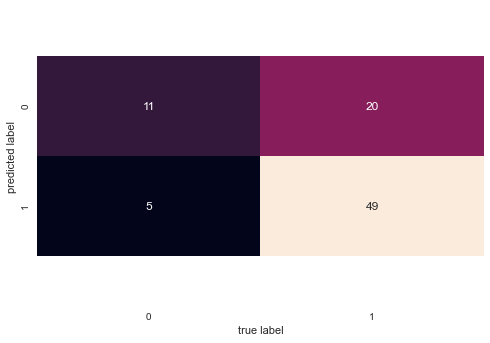

In [24]:
# set up and display confusion matrix

mat = confusion_matrix(y_predict, y_test)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # add 0.5 to the bottom
t -= 0.5 # subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

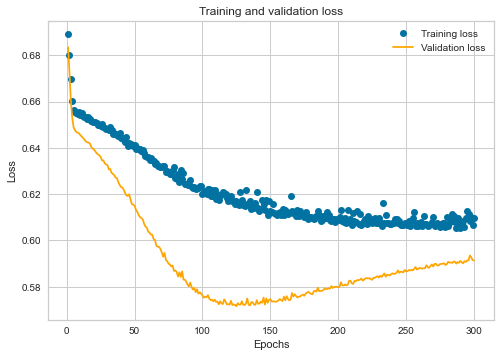

In [25]:
# set up and display learning curve (loss) by epoch

history_dict = history.history

loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

epochs = range(1, len(loss_values) + 1) 

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

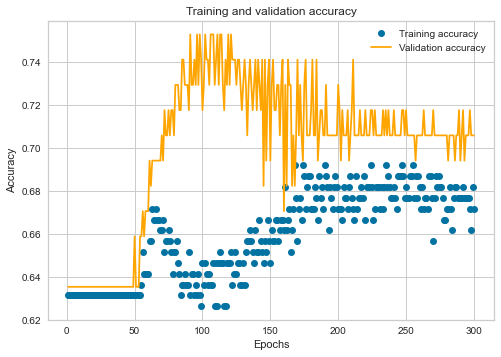

In [26]:
# set up and display learning curve (accuracy) by epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()